# Определение возраста покупателей

Сетевой супермаркет внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;

- Контролировать добросовестность кассиров при продаже алкоголя.

Требуется построить модель, которая по фотографии определит приблизительный возраст человека.

Данные: набор фотографий людей с указанием возраста.

## Исследовательский анализ данных

Импортируем необходимые библиотеки:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Выведем размер выборки:

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
print(labels.shape)

(7591, 2)


Распределение возраста:

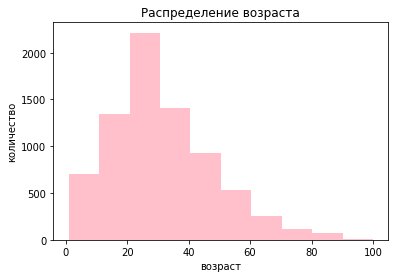

In [3]:
plt.hist(labels["real_age"], color = 'pink')
plt.title('Распределение возраста')
plt.xlabel('возраст')
plt.ylabel('количество')
plt.show()

In [4]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


Вывод фотографий:

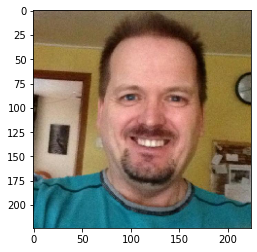

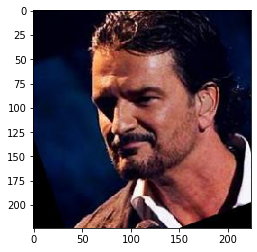

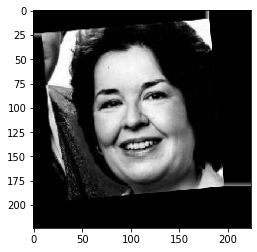

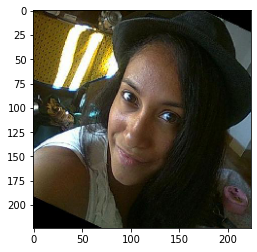

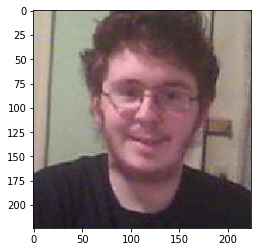

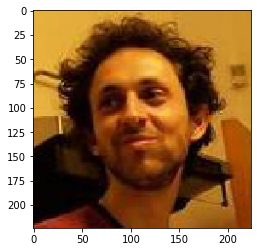

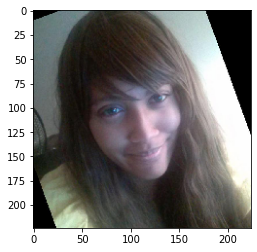

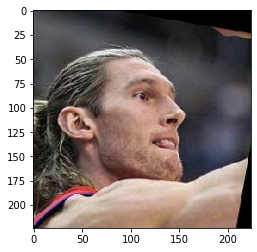

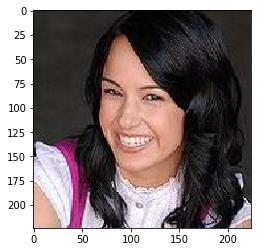

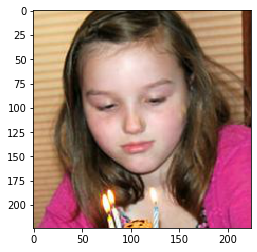

In [5]:
for _ in range(10):
    img, label = train_gen_flow.next()
    plt.imshow(img[0])
    plt.show()

В датасете представлены фотографии лиц людей различных возрастов. Всего в выборке 7591 фотография. Большая часть фотографий людей возрастом 20-40 лет.

Фотографии являются растровыми изображениями.

У фотографий разные яркость, контраст и гамма

## Обучение модели

```python
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPooling2D, AvgPool2D, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50


def load_train(path):
    train_datagen = ImageDataGenerator(validation_split=0.25, rescale=1/255.,
                                       width_shift_range = 0.2 ,
                                       height_shift_range =0.2 
                                       )
    labels = pd.read_csv(f'{path}labels.csv')
    train_datagen_flow = train_datagen.flow_from_dataframe(dataframe=labels,
        directory=f'{path}/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)
    return train_datagen_flow 

def load_test(path):
    labels = pd.read_csv(f'{path}labels.csv')
    test_datagen = ImageDataGenerator(validation_split=0.25, rescale=1/255.)
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory= f'{path}/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)
    return test_datagen_flow


def create_model(input_shape):
    optimizer = Adam(learning_rate=0.0001)
    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet', 
                    include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu')) 
    model.compile(optimizer=optimizer, loss='mse',  metrics=['mae']) 
    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=10,
               steps_per_epoch=None, validation_steps=None):
    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)

    return model
```

```python
178/178 - 122s - loss: 241.7409 - mae: 11.1409 - val_loss: 764.2930 - val_mae: 22.5709
Epoch 2/10
178/178 - 122s - loss: 86.9082 - mae: 7.0468 - val_loss: 968.9831 - val_mae: 26.2542
Epoch 3/10
178/178 - 109s - loss: 58.8910 - mae: 5.8281 - val_loss: 812.5680 - val_mae: 23.8027
Epoch 4/10
178/178 - 111s - loss: 44.9967 - mae: 5.1539 - val_loss: 147.8951 - val_mae: 8.4802
Epoch 5/10
178/178 - 113s - loss: 36.9620 - mae: 4.6725 - val_loss: 55.8239 - val_mae: 5.6303
Epoch 6/10
178/178 - 111s - loss: 29.9818 - mae: 4.2711 - val_loss: 26.8859 - val_mae: 4.0001
Epoch 7/10
178/178 - 112s - loss: 25.1039 - mae: 3.8795 - val_loss: 49.1461 - val_mae: 5.7132
Epoch 8/10
178/178 - 118s - loss: 22.5796 - mae: 3.7148 - val_loss: 20.8854 - val_mae: 3.4839
Epoch 9/10
178/178 - 120s - loss: 20.3622 - mae: 3.4740 - val_loss: 55.9538 - val_mae: 5.9425
Epoch 10/10
178/178 - 120s - loss: 18.4098 - mae: 3.2865 - val_loss: 25.0116 - val_mae: 3.7848
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
178/178 - 31s - loss: 25.0116 - mae: 3.7848
Test MAE: 3.7848
```

## Анализ обученной модели

Значение MAE обученной модели = 3.7848.

Ошибка составила 4% от фактических значений.

Вывод: был проанализирован датасет фотографий людей, распределение возрастов в датасете; была построена модель, которая по фотографии определит приблизительный возраст человека.